# Project

Have you once played with paper planes when you were a child? Back to that moment, you might wish that your plane would fly as much higher or longer time as it can. So how to realize your fly dream? The trick is behind airfoils. If there were enough lift on your airfoils, then your plane would maintain higher altitude as much longer as it could.

In case you consider a paper plane is childish, let us talk about one kind of flying sport, which is just like playing a paper plane, gliders.

![glider]("./mae6226/Project/Pipistrel-G2-Glider-0211a.jpg")

Then the next question is coming, what kinds of airfoils would produce enough lift to enable the plane fly at a high altitude. Let me show you some different types of airfoils before I tell you the answer.

![glider]("./mae6226/Project/Pipistrel-G2-Glider-0211a.jpg")

![glider]("./mae6226/Project/Pipistrel-G2-Glider-0211a.jpg")

This is the NACA0012 airfoil. As you can see from the picture, the airfoil is symmetrical up and down, which is convenient to manufacture and easy to fly upside down. Additionally, if you consider the thickness of NACA0012, it is a bit thicker so it can have a larger attack angle, but theoretically, the resistance can be larger as well.

So whether is the NACA0012 is the ideal airfoil for gliders? Unfortunately, modern gliders are tending to be made of high-strength, light-weight materials. Also, considering gliders have no power engines, airfoils with large thickness may increase the weight of gliders, so the best choice is clearly not the NACA00 seris. Then we are back at the starting point. What kinds of airfoils will satisfy our demanding requirements? One that can produce huge lift to stay longer time in the sky with no thrust? The answer is yes, there is one kind of airfoil that we dreamed, which is the Eppler high lift series airfoils.

How can they do that? Do that make sense in physics? Let us recall the paper that we have from the beginning of the semester--"How do wings work?". From the paper, we know "any shape that introduces curvature into the ﬂow ﬁeld can generate lift." Just because of the existing of curvature from the airfoil, when there is a freestream coming, pressure from the lower surface is larger than pressure from the upper surface. Then the lift is produced. Due to the distinctive shapes of different airfoils, the bigger curvature an airfoil has, the bigger lift the plane will get. Now, when considering the weight is much lighter than the thick ones we meet before, Eppler series become the best airfoils for gliders.

So how to prove the theory. Here, i will use vortex-source panel methods to compute the lift on both Eppler E420 and NACA0012 airfoils at the same attack angles for several times. Then we will meet the truth.

In [1]:
import math
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

$$
y = x^2
$$

![tag]("./path/to/image.png")

### Let us see how Eppler E420 looks like in python

In [2]:
x, y = numpy.loadtxt('e420.dat', dtype=float, unpack=True)

(-0.05, 0.2)

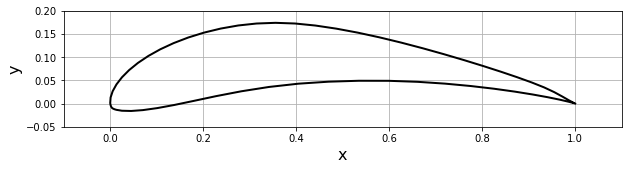

In [3]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.05, 0.2)

Now we have our airfoil, then we will have to define the class of our panel for E420.

In [4]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        if self.beta <= numpy.pi:
            self.loc = 'upper'  
        else:
            self.loc = 'lower'  

        
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [5]:
x_ends = x
y_ends = y

N = 70
panels = numpy.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

(-0.05, 0.2)

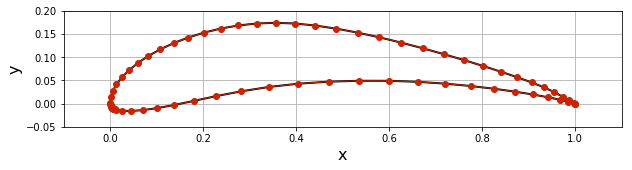

In [6]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.05, 0.2)

### Define free stream

The airfoil is immersed in a free-stream $(U_\infty$,$\alpha)$ where $U_\infty$ and $\alpha$ are the velocity magnitude and angle of attack.

In [7]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)

In [8]:
freestream = Freestream(u_inf=1.0, alpha=4.0)

We are going to use the function `integral` to compute the different integrals with the SciPy function `integrate.quad`:

In [9]:
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

### Flow tangency boundary condition

A constant vortex strength $\gamma$ will be added to each panel (all panels have the same, constant vortex-sheet strength). Thus, using the principle of superposition, the velocity potential becomes:

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

The flow tangency boundary condition is applied at every panel center:

$$0 = \vec{V}\cdot\vec{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

i.e.

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

The derivation of the first integral is:

$$\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$, and

$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$

$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$

We now need to derive the last integral of the boundary equation:

$$\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$.

We first define the function `source_contribution_normal` to build the source matrix, i.e. the weight from each source on the normal velocity of each panel:

In [10]:
def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

Then, we define `vortex_contribution_normal` to build the vortex matrix:

In [11]:
def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

Let's call both of these functions to create the source matrix `A_source` and the vortex matrix `B_vortex`:

In [12]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

### Enforcing the Kutta condition

To enforce the *Kutta-condition*, we state that the pressure coefficient on the first panel must be equal to that on the last panel:

$$C_{p_1} = C_{p_{N}}$$

Using the definition of the pressure coefficient $C_p = 1-\left(\frac{V}{U_\infty}\right)^2$, the Kutta-condition implies that the magnitude of the velocity at the first panel center must equal the magnitude of the last panel center:

$$V_1^2 = V_N^2$$

Since the flow tangency condition requires that $V_{n_1} = V_{n_N} = 0$, we end up with the following *Kutta-condition*:

$$V_{t_1} = - V_{t_N}$$

(the minus sign comes from the reference axis we chose for the normal and tangential vectors).

Let's derive the tangential velocity for every panel, since it will be useful to compute the pressure coefficient.

$$V_{t_i} = \frac{\partial}{\partial t_i} \left(\phi\left(x_{c_i},y_{c_i}\right)\right)$$

i.e.,

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial t_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial t_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$


which gives

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$

where $\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i$ and $\frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$.

 show that:

* the matrix resulting from the contribution of the vortices on the normal velocity, $B^n$, is **exactly** the matrix resulting from the contribution of the sources on the tangential velocity, $A^t$, i.e.

$$B^n_{ij}=A^t_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

* the matrix resulting from the contribution of the vortices on the tangential velocity, $B^t$, is the **opposite** of the matrix resulting from the contribution of the sources on the normal velocity, $A^n$, i.e.

$$B^t_{ij}=-A^n_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

where the superscripts $n$ and $t$ denote the normal and tangential velocity components, respectively.

Thus, the Kutta condition can be cast in the following form

$$
\begin{bmatrix}
(A^t_{11}+A^t_{N1}) \\
\vdots \\ 
(A^t_{1N}+A^t_{NN}) \\
\left( \sum_{j=1}^N (B^t_{1j}+B^t_{Nj}) \right)
\end{bmatrix}^T
\begin{bmatrix}
\sigma_1 \\
\vdots \\
\sigma_N \\
\gamma
\end{bmatrix}
=
-(b^t_1+b^t_N)
$$

Let's define a function `kutta_condition` that does the job:

In [13]:
def kutta_condition(A_source, B_vortex):
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

### Building the linear system

Here, we build and solve the linear system of equations of the form

$$[A][\sigma,\gamma] = [b]$$

where the $N+1 \times N+1$ matrix $[A]$ contains three blocks: an $N \times N$ source matrix (the same one of Lesson 10), an $N \times 1$ vortex array to store the weight of the variable $\gamma$ at each panel, and a $1 \times N+1$ Kutta array that repesents our Kutta-condition.

We are going to use the function `integral` from above to compute the different integrals with the SciPy function `integrate.quad`:

In [14]:
def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

On the right-hand side, we store everything that does not depend on the unknown strengths.

In [15]:
def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size + 1, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

In [16]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

As in the previous lesson, we solve the linear system using the Scipy function `linalg.solve`. Then we store the results in the attribute `sigma` of each `Panel` object. We also create a variable `gamma` to store the value of the constant vortex strength.

In [17]:
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    

gamma = strengths[-1]

## Surface pressure coefficient

The pressure coefficient at the $i$-th panel center is:

$$C_{p_i} = 1 - \left(\frac{V_{t_i}}{U_\infty}\right)^2$$

So, we have to compute the tangential velocity at each panel center using the function `compute_tangential_velocity`:

In [18]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [19]:
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

And we define a function `compute_pressure_coefficient` to compute the surface pressure coefficient:

In [20]:
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [21]:
compute_pressure_coefficient(panels, freestream)

Time to plot the result!

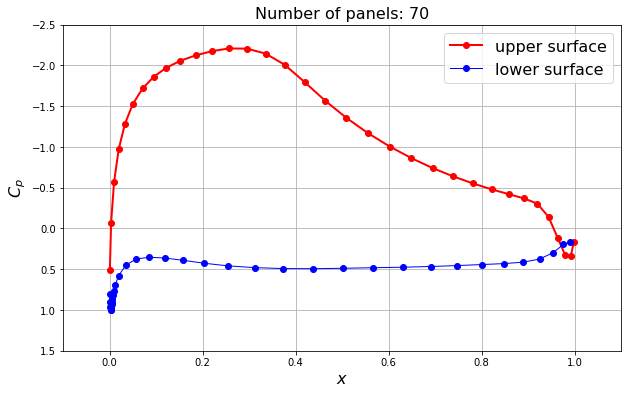

In [22]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.5, -2.5)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16)

### Accuracy check

For a closed body, the sum of all the source strengths must be zero. If not, it means the body would be adding or absorbing mass from the flow! Therfore, we should have

$$\sum_{i=1}^{N} \sigma_i l_i = 0$$

where $l_i$ is the length of the $i^{\text{th}}$ panel.

With this, we can get a measure of the accuracy of the source panel method.

In [23]:
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -0.007258


## Lift coefficient

The lift  is given by the Kutta-Joukowski theorem, $L = \rho \Gamma U_\infty$, 
where $\rho$ is the fluid density. The total circulation $\Gamma$ is given by:

$$\Gamma = \sum_{i=1}^N \gamma l_i$$

Finally, the lift coefficient is given by:

$$C_l = \frac{\sum_{i=1}^N \gamma l_i}{\frac{1}{2}U_\infty c}$$

 with $c$ the chord-length of the airoil

In [24]:
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 1.762


## Lift

In [25]:
L = 0.5 * c * cl
print('lift: L = {:0.3f}'.format(L))

lift: L = 0.881


## Streamlines onto a mesh grid

To get a streamline plot, we have to create a mesh (like we've done in all *AeroPython* lessons!) and compute the velocity field onto it. Knowing the strength of every panel, we find the $x$-component of the velocity by taking derivative of the velocity potential in the $x$-direction, and the $y$-component by taking derivative in the $y$-direction:

$$u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

$$v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

Notice that here we call the funcion `integral()` with $1,0$ as the final arguments when calculating the derivatives in the $x$-direction, and $0,1$ for the derivatives in th $y$-direction.

In addition, we use the function `numpy.vectorize()` (as we did in [Lesson 8](08_Lesson08_sourceSheet.ipynb)) to avoid the nested loops over the domain.

In [26]:
def get_velocity_field(panels, freestream, X, Y):
    
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    vec_intregral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1.0, 0.0) - gamma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0.0, 1.0) - gamma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
    
    return u, v

In [27]:
nx, ny = 50, 50  
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.4, 0.5
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

u, v = get_velocity_field(panels, freestream, X, Y)

(-0.4, 0.5)

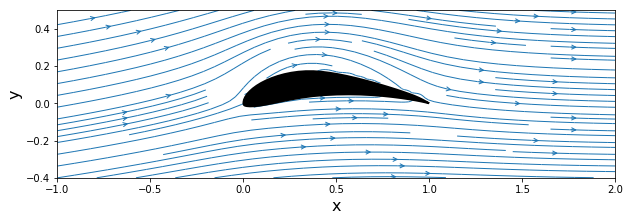

In [28]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

We can now calculate the pressure coefficient.

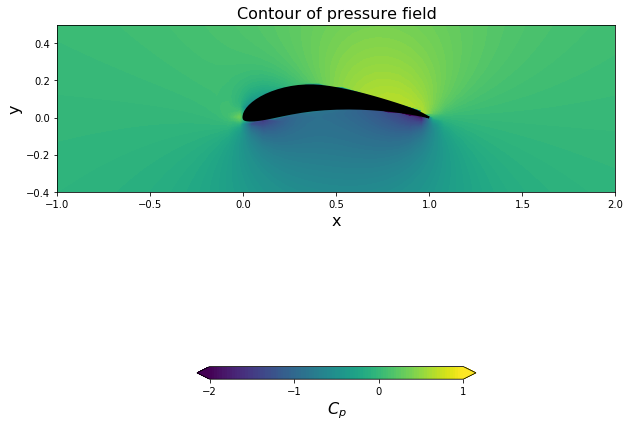

In [29]:
cp = 1.0 - (u**2 + v**2) / freestream.u_inf**2

width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16)

In [32]:
x2, y2 = numpy.loadtxt('naca0012.dat', dtype=float, unpack=True)

(-0.1, 0.1)

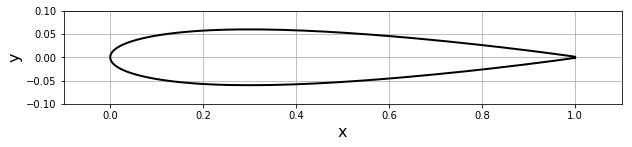

In [39]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x2, y2, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1)

In [30]:
def lift(alpha):
    freestream = Freestream(u_inf, alpha)
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)
    strengths = numpy.linalg.solve(A, b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    c = abs(max(panel.xa for panel in panels) -
            min(panel.xa for panel in panels))
    cl = (gamma * sum(panel.length for panel in panels) /
          (0.5 * freestream.u_inf * c))
    L = 0.5 * c * cl
    
    return L

In [31]:
u_inf = 1.0
alpha=4.0
G = 20
L = numpy.zeros((2, G), dtype=float)
for i in range(G):
    L[0, i-1] = lift(alpha + (i+1))
    L[1, i-1] = alpha + (i+1)

In [33]:
x_ends2 = x2
y_ends2 = y2

N = 129
panels_0012 = numpy.empty(N, dtype=object)
for i in range(N):
    panels_0012[i] = Panel(x_ends2[i], y_ends2[i], x_ends2[i + 1], y_ends2[i + 1])

In [34]:
def lift_0012(alpha):
    freestream = Freestream(u_inf, alpha)
    A_source2 = source_contribution_normal(panels_0012)
    B_vortex2 = vortex_contribution_normal(panels_0012)
    A2 = build_singularity_matrix(A_source2, B_vortex2)
    b2 = build_freestream_rhs(panels_0012, freestream)
    strengths2 = numpy.linalg.solve(A2, b2)
    for i , panel in enumerate(panels_0012):
        panel.sigma = strengths2[i]
    gamma2 = strengths2[-1]
    compute_tangential_velocity(panels_0012, freestream, gamma2, A_source2, B_vortex2)
    compute_pressure_coefficient(panels_0012, freestream)
    c2 = abs(max(panel.xa for panel in panels_0012) -
            min(panel.xa for panel in panels_0012))
    cl2 = (gamma2 * sum(panel.length for panel in panels_0012) /
          (0.5 * freestream.u_inf * c2))
    L_0012 = 0.5 * c2 * cl2
    
    return L_0012

In [35]:
L_0012 = numpy.zeros((2, G), dtype=float)
for i in range(G):
    L_0012[0, i-1] = lift_0012(alpha + (i+1))
    L_0012[1, i-1] = alpha + (i+1)

(0.0, 2.25)

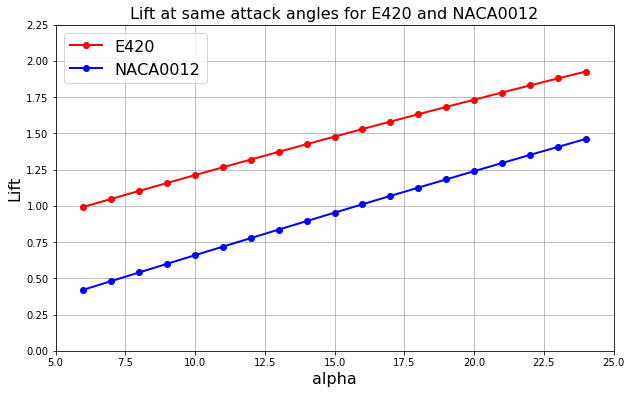

In [38]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('alpha', fontsize=16)
pyplot.ylabel('Lift', fontsize=16)
pyplot.plot(L[1, :-1], L[0, :-1],
               label='E420',
               color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot(L_0012[1, :-1], L_0012[0, :-1],
               label='NACA0012',
               color='b', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.title('Lift at same attack angles for E420 and NACA0012', fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(5.0, 25.0)
pyplot.ylim(0.0, 2.25)